In [2]:
%autosave 60


Autosaving every 60 seconds


In [3]:
5

5

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import catboost

In [6]:
import torch
print(torch.__version__)  # Должно быть 2.5.1+cu121
print(torch.cuda.is_available())  # Должно быть True

2.5.1+cu121
True


In [6]:
# pip install -q razdel pymorphy3 pymorphy3-dicts-ru torch transformers datasets scikit-learn wordcloud graphviz seaborn pandas numpy

In [7]:
# pip install --upgrade ipywidgets

In [8]:
# pip install 'accelerate>=0.26.0'

In [7]:
import os 


homebrew_path_m_series = '/opt/homebrew/bin'

if os.path.exists(homebrew_path_m_series):
    os.environ["PATH"] += os.pathsep + homebrew_path_m_series

Что будем делать сегодня
1.  **Подготовим данные**
2.  **Построим Baseline**
3.  **Погрузимся в Word Embeddings**
4.  **Учтем порядок слов**
5.  **Сделаем fine tuning**

In [38]:
# --- Системные и общие ---
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# --- SKlearn ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# --- NLP-инструменты ---
import nltk
from nltk.corpus import stopwords
from razdel import tokenize as razdel_tokenize
import pymorphy3
from wordcloud import WordCloud

# --- PyTorch & Transformers ---
# import torch
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoModel
from datasets import Dataset as HFDataset

# --- Визуализация ---
from graphviz import Digraph

# --- Константы и настройка среды ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Определяем устройство: MPS (Apple Silicon GPU), CUDA или CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(RANDOM_STATE)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(RANDOM_STATE)
else:
    device = torch.device("cpu")

print(f"✅ Используемое устройство: {device}")

# --- Инициализация лидерборда ---
leaderboard = pd.DataFrame(columns=['Метод', 'R2_Score'])

✅ Используемое устройство: cuda


In [9]:
# Загружаем данные из файлов соревнования
try:
    full_train_df = pd.read_csv('teta-nn-1-2025/train.csv')
    test_df = pd.read_csv('teta-nn-1-2025/test.csv')
except FileNotFoundError:
    print("Ошибка: Убедитесь, что файлы train.csv и test.csv находятся в папке 'teta-nn-1-2025/'")
    # Создадим заглушку, чтобы ноутбук мог работать дальше
    full_train_df = pd.DataFrame({
        'title': ['Python Developer'], 'location': ['Москва'], 'company': ['Yandex'],
        'skills': ['Python, SQL'], 'description': ['Developing cool services'],
        'experience_from': [3], 'salary_from': [200], 'log_salary_from': [5.3]
    })
    test_df = full_train_df.copy()


# Разбиваем исходный train на обучающую и валидационную выборки
train_df, val_df = train_test_split(
    full_train_df, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

# Сбрасываем индексы для удобства
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Создаем единое текстовое поле для анализа
text_cols = ['title', 'location', 'company', 'skills', 'description']
for df in [train_df, val_df, test_df]:
    # Заполняем пропуски пустыми строками, чтобы избежать ошибок
    df[text_cols] = df[text_cols].fillna('')
    # Объединяем текстовые колонки через разделитель
    df['full_text'] = df[text_cols].agg(' | '.join, axis=1)

print("Пример данных из train:")
display(train_df[['full_text', 'log_salary_from']].head(3))

Пример данных из train:


,full_text,log_salary_from
0,QA Engineer | Москва (м. Сколково / м. Крылатс...,5.298317
1,Senior Backend QA engineer | Санкт-Петербург |...,5.010635
2,Python разработчик (Django) | Москва | Hammer ...,3.912023


## 🧹 1. Предобработка текста

"Сырые" тексты вакансий полны "мусора": знаки препинания, разный регистр, множество форм одного слова (`инженер`, `инженера`, `инженеру`). Чтобы модели могли эффективно работать, нам нужно привести всё к единому, чистому виду.

Наш пайплайн обработки:
1.  **Токенизация**: Разбиваем текст на слова (токены).
2.  **Лемматизация**: Приводим каждое слово к его начальной форме (лемме). Например, "требования" -> "требование". Используем `pymorphy3`.
3.  **Удаление стоп-слов**: Выкидываем неинформативные слова типа "и", "в", "на", "мы".

In [10]:
# Загружаем стоп-слова
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('russian'))
# Добавим специфичные для вакансий стоп-слова
stop_words.update(['наш', 'компания', 'команда', 'работа', 'вакансия', 'искать'])

# Инициализируем лемматизатор pymorphy3
morph = pymorphy3.MorphAnalyzer()

def preprocess_text(text: str) -> str:
    """Полный цикл предобработки текста с использованием pymorphy3."""
    # 1. Токенизация
    tokens = [token.text for token in razdel_tokenize(text)]
    # 2. Приведение к нижнему регистру и удаление не-буквенных токенов
    lower_tokens = [token.lower() for token in tokens if token.isalpha()]
    # 3. Лемматизация и удаление стоп-слов
    lemmas = [morph.parse(token)[0].normal_form for token in lower_tokens]
    cleaned_lemmas = [lemma for lemma in lemmas if lemma not in stop_words]
    return " ".join(cleaned_lemmas)

# Демонстрируем работу на одном примере
sample_text = train_df['full_text'].iloc[0]
print(f"ИСХОДНЫЙ ТЕКСТ: '{sample_text[:200]}...'")
print(f"ОБРАБОТАННЫЙ ТЕКСТ: '{preprocess_text(sample_text)}'")

# Применяем ко всем данным
tqdm.pandas(desc="Preprocessing Train")
train_df['processed_text'] = train_df['full_text'].progress_apply(preprocess_text)
tqdm.pandas(desc="Preprocessing Val")
val_df['processed_text'] = val_df['full_text'].progress_apply(preprocess_text)

ИСХОДНЫЙ ТЕКСТ: 'QA Engineer | Москва (м. Сколково / м. Крылатское) | getmatch agency | Python, Java, Go, C# | Наша компания сохраняет атмосферу стартапа, обеспечивая динамичность и стремление к результатам в сочетани...'
ОБРАБОТАННЫЙ ТЕКСТ: 'qa engineer москва м сколково м крылатский getmatch agency python java go c сохранять атмосфера стартап обеспечивать динамичность стремление результат сочетание комфорт стабильность корпоративный среда трудиться создание будущее российский мобильный связь ключевой продукт российский оператор базовый станция lte g разработать основа принцип открытый архитектура open ran приглашать талантливый специалист присоединиться просто сотрудник сторонник разделять страсть прогресс инновация предстоять заниматься участвовать процесс контроль качество разный этап жизненный цикл разрабатывать средство автоматизация функциональный нагрузочный тестирование разрабатывать тестовый документация участвовать лабораторный приёмочный испытание также составлять отчётный 

Preprocessing Train:   0%|          | 0/12500 [00:00<?, ?it/s]

Preprocessing Val:   0%|          | 0/4167 [00:00<?, ?it/s]

In [ ]:
5

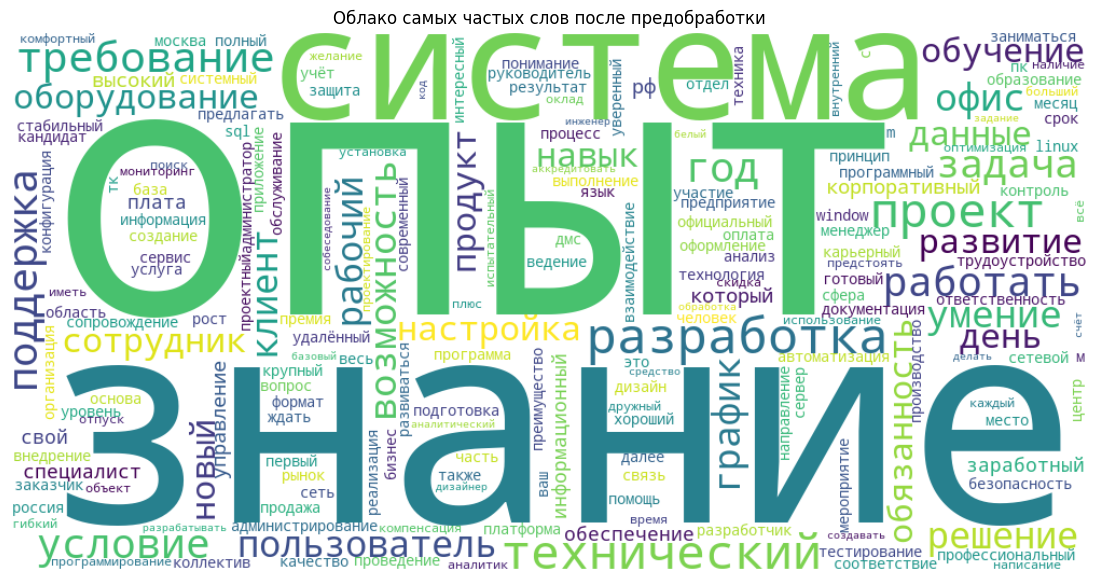

In [11]:
all_text = " ".join(train_df['processed_text'])
if all_text:
    wordcloud = WordCloud(width=1000, height=500, background_color='white', collocations=False).generate(all_text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако самых частых слов после предобработки')
    plt.show()
else:
    print("Недостаточно данных для построения облака слов.")

## 🔢 2. Подход №1: TF-IDF + Линейная модель (Наш Baseline) + (добавил catboost вместо линейной модели)

**TF-IDF (Term Frequency-Inverse Document Frequency)** — это классический способ превратить текст в числа.

*   **TF (Term Frequency)**: Чем чаще слово (например, "Python") встречается в вакансии, тем оно важнее для *этой* вакансии.
*   **IDF (Inverse Document Frequency)**: Чем в большем количестве вакансий встречается слово (например, "опыт"), тем оно *менее* уникально, и его вес нужно понизить.

На выходе мы получаем матрицу "вакансия-слово", которую подадим в линейную регрессию.

In [17]:
# Создаем векторизатор
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Обучаем векторизатор и преобразуем данные
X_train_tfidf = vectorizer.fit_transform(train_df['processed_text'])
X_val_tfidf = vectorizer.transform(val_df['processed_text'])

# Наши целевые переменные
y_train = train_df['log_salary_from']
y_val = val_df['log_salary_from']

# Обучаем Ridge регрессию
model_tfidf = Ridge(random_state=RANDOM_STATE)
model_tfidf.fit(X_train_tfidf, y_train)

# Делаем предсказания и считаем метрику
preds_tfidf = model_tfidf.predict(X_val_tfidf)
r2_tfidf = r2_score(y_val, preds_tfidf)

print(f"R² score для TF-IDF + Ridge: {r2_tfidf:.4f}")

# Обновляем лидерборд
leaderboard.loc[0] = ['TF-IDF + Ridge', r2_tfidf]
display(leaderboard)

R² score для TF-IDF + Ridge: 0.6636


,Метод,R2_Score
0,TF-IDF + Ridge,0.663552


In [13]:
from catboost import CatBoostRegressor, Pool


# Преобразуем в dense массивы
X_train_dense = vectorizer.fit_transform(train_df['processed_text']).toarray()
X_val_dense = vectorizer.transform(val_df['processed_text']).toarray()

# 2. Настройка CatBoost (только CPU для стабильности)
catboost_params = {
    'iterations': 4000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'eval_metric': 'R2',
    'random_seed': RANDOM_STATE,
    'early_stopping_rounds': 50,
    'verbose': 100,
    'task_type': 'CPU',  # Принудительно используем CPU
    'thread_count': 4    # Используем 4 ядра
}

# 3. Обучение модели
model = CatBoostRegressor(**catboost_params)
model.fit(
    X_train_dense, 
    y_train,
    eval_set=(X_val_dense, y_val),
    use_best_model=True
)

# 4. Предсказание и оценка
preds = model.predict(X_val_dense)
r2 = r2_score(y_val, preds)
print(f"R² score для TF-IDF + CatBoost: {r2:.4f}")

0:	learn: 0.0356164	test: 0.0362755	best: 0.0362755 (0)	total: 817ms	remaining: 54m 28s
100:	learn: 0.5775318	test: 0.5625731	best: 0.5625731 (100)	total: 58.9s	remaining: 37m 53s
200:	learn: 0.6390422	test: 0.6080030	best: 0.6080030 (200)	total: 1m 56s	remaining: 36m 44s
300:	learn: 0.6795395	test: 0.6299601	best: 0.6299601 (300)	total: 2m 54s	remaining: 35m 41s
400:	learn: 0.7086411	test: 0.6411548	best: 0.6411548 (400)	total: 3m 52s	remaining: 34m 42s
500:	learn: 0.7310373	test: 0.6486916	best: 0.6486916 (500)	total: 4m 49s	remaining: 33m 41s
600:	learn: 0.7479358	test: 0.6536142	best: 0.6536142 (600)	total: 5m 47s	remaining: 32m 46s
700:	learn: 0.7637734	test: 0.6583964	best: 0.6583964 (700)	total: 6m 45s	remaining: 31m 48s
800:	learn: 0.7782528	test: 0.6625200	best: 0.6625200 (800)	total: 7m 43s	remaining: 30m 51s
900:	learn: 0.7915207	test: 0.6656076	best: 0.6656118 (896)	total: 8m 41s	remaining: 29m 52s
1000:	learn: 0.8033180	test: 0.6682823	best: 0.6682823 (1000)	total: 9m 39s	

In [14]:
# 2. Предобработка текста (аналогично train)
test_df['processed_text'] = test_df['full_text'].apply(preprocess_text)

# 3. Векторизация текста
X_test_tfidf = vectorizer.transform(test_df['processed_text']).toarray()

# 4. Получаем предсказания
test_preds = model.predict(X_test_tfidf)

# 5. Создаем DataFrame с результатами
results = pd.DataFrame({
    'index': test_df.index,
    'prediction': test_preds
})

# 6. Сохраняем в CSV (без индексов, с заголовком)
results.to_csv('predictions.csv', index=False)

print("Предсказания сохранены в predictions.csv")

Предсказания сохранены в predictions.csv


Написал собственную архетиктуру


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import r2_score

# 1. Создаем PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, targets, vectorizer):
        self.texts = texts
        self.targets = targets
        self.vectorizer = vectorizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        vector = self.vectorizer.transform([text]).toarray()[0].astype(np.float32)
        target = np.array([self.targets[idx]], dtype=np.float32)
        return torch.from_numpy(vector), torch.from_numpy(target)

# 2. Архитектура нейросети
class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.net(x)

# 3. Подготовка данных для PyTorch
X_train_tensor = torch.from_numpy(X_train_tfidf.toarray().astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.values.reshape(-1, 1).astype(np.float32))
X_val_tensor = torch.from_numpy(X_val_tfidf.toarray().astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.values.reshape(-1, 1).astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# 4. Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SalaryPredictor(input_size=X_train_tfidf.shape[1]).to(device)

# 5. Обучение модели
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

best_r2 = -np.inf
for epoch in range(100):
    model.train()
    train_loss = 0
    
    # Training
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            preds = model(X_val)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(y_val.cpu().numpy())
    
    val_r2 = r2_score(val_true, val_preds)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val R2: {val_r2:.4f}')
    
    # Save best model
    if val_r2 > best_r2:
        best_r2 = val_r2
        torch.save(model.state_dict(), 'best_model.pth')
    
    scheduler.step(train_loss)

# 6. Предсказание на тестовых данных
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

X_test_tfidf = vectorizer.transform(test_df['processed_text'])
X_test_tensor = torch.from_numpy(X_test_tfidf.toarray().astype(np.float32)).to(device)

with torch.no_grad():
    test_preds = model(X_test_tensor).cpu().numpy().flatten()

# 7. Сохранение результатов
results = pd.DataFrame({
    'index': test_df.index,
    'prediction': test_preds
})
results.to_csv('predictions.csv', index=False)

print(f"Лучший R2 на валидации: {best_r2:.4f}")
print("Предсказания сохранены в predictions.csv")

Epoch 1, Train Loss: 1.1879, Val R2: 0.5072
Epoch 2, Train Loss: 0.2247, Val R2: 0.4958
Epoch 3, Train Loss: 0.1834, Val R2: 0.5578
Epoch 4, Train Loss: 0.1601, Val R2: 0.5756
Epoch 5, Train Loss: 0.1415, Val R2: 0.5440
Epoch 6, Train Loss: 0.1263, Val R2: 0.5560
Epoch 7, Train Loss: 0.1198, Val R2: 0.5631
Epoch 8, Train Loss: 0.1127, Val R2: 0.5404
Epoch 9, Train Loss: 0.1049, Val R2: 0.6010
Epoch 10, Train Loss: 0.0963, Val R2: 0.6166
Epoch 11, Train Loss: 0.0953, Val R2: 0.5963
Epoch 12, Train Loss: 0.0899, Val R2: 0.5972
Epoch 13, Train Loss: 0.0863, Val R2: 0.6133
Epoch 14, Train Loss: 0.0850, Val R2: 0.5862
Epoch 15, Train Loss: 0.0766, Val R2: 0.5096
Epoch 16, Train Loss: 0.0745, Val R2: 0.6357
Epoch 17, Train Loss: 0.0718, Val R2: 0.6297
Epoch 18, Train Loss: 0.0683, Val R2: 0.6145
Epoch 19, Train Loss: 0.0666, Val R2: 0.6013
Epoch 20, Train Loss: 0.0612, Val R2: 0.6020
Epoch 21, Train Loss: 0.0602, Val R2: 0.6336
Epoch 22, Train Loss: 0.0539, Val R2: 0.6444
Epoch 23, Train Los

In [40]:
# --- PyTorch & Transformers ---
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset as HFDataset

# Используем более легкую модель для русского языка
model_name = "cointegrated/rubert-tiny"  # Компактная русскоязычная модель
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

def get_bert_embeddings(texts, batch_size=32):  # Увеличиваем batch_size, так как модель легче
    """Получаем BERT эмбединги для списка текстов."""
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch = texts[i:i+batch_size]
        
        # Токенизация с уменьшенной максимальной длиной
        inputs = tokenizer(
            batch, 
            padding=True, 
            truncation=True, 
            max_length=256,  # Уменьшаем максимальную длину
            return_tensors="pt"
        ).to(device)
        
        # Получаем эмбединги
        with torch.no_grad():
            outputs = bert_model(**inputs)
        
        # Используем среднее всех токенов как представление текста (альтернатива [CLS])
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

# Получаем BERT эмбединги
print("Получение эмбедингов для обучающей выборки...")
X_train_bert = get_bert_embeddings(train_df['processed_text'].tolist())
print("Получение эмбедингов для валидационной выборки...")
X_val_bert = get_bert_embeddings(val_df['processed_text'].tolist())

# Наши целевые переменные
y_train = train_df['log_salary_from']
y_val = val_df['log_salary_from']

# Обучаем Ridge регрессию на BERT эмбедингах
print("Обучение модели Ridge...")
model_bert = Ridge(random_state=RANDOM_STATE)
model_bert.fit(X_train_bert, y_train)

# Делаем предсказания и считаем метрику
print("Оценка качества модели...")
preds_bert = model_bert.predict(X_val_bert)
r2_bert = r2_score(y_val, preds_bert)

print(f"R² score для rubert-tiny + Ridge: {r2_bert:.4f}")

# Обновляем лидерборд
leaderboard.loc[0] = ['rubert-tiny + Ridge', r2_bert]
display(leaderboard)

Получение эмбедингов для обучающей выборки...


Processing batches:   0%|          | 0/391 [00:00<?, ?it/s]

Получение эмбедингов для валидационной выборки...


Processing batches:   0%|          | 0/131 [00:00<?, ?it/s]

Обучение модели Ridge...
Оценка качества модели...
R² score для rubert-tiny + Ridge: 0.4482


,Метод,R2_Score
0,rubert-tiny + Ridge,0.448214


In [42]:
# --- PyTorch & Transformers ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset as HFDataset

# Определяем простую нейронную сеть
class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Создаем датасет для PyTorch
class TextDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.embeddings = embeddings
        self.targets = targets
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return {
            'embedding': torch.tensor(self.embeddings[idx], dtype=torch.float32),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

# Используем более легкую модель для русского языка
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

def get_bert_embeddings(texts, batch_size=32):
    """Получаем BERT эмбединги для списка текстов."""
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch, 
            padding=True, 
            truncation=True, 
            max_length=256,
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            outputs = bert_model(**inputs)
        
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

# Получаем BERT эмбединги
print("Получение эмбедингов...")
X_train_bert = get_bert_embeddings(train_df['processed_text'].tolist())
X_val_bert = get_bert_embeddings(val_df['processed_text'].tolist())

# Подготовка данных
train_dataset = TextDataset(X_train_bert, train_df['log_salary_from'].values)
val_dataset = TextDataset(X_val_bert, val_df['log_salary_from'].values)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Инициализация модели
input_size = X_train_bert.shape[1]
model = SalaryPredictor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 100
best_r2 = -float('inf')

print("Начинаем обучение нейронной сети...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch in train_loader:
        embeddings = batch['embedding'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * embeddings.size(0)
    
    # Валидация
    model.eval()
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for batch in val_loader:
            embeddings = batch['embedding'].to(device)
            targets = batch['target'].cpu().numpy()
            
            outputs = model(embeddings).squeeze().cpu().numpy()
            val_preds.extend(outputs)
            val_targets.extend(targets)
    
    r2 = r2_score(val_targets, val_preds)
    train_loss = train_loss / len(train_loader.dataset)
    
    print(f"Эпоха {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | R²: {r2:.4f}")
    
    if r2 > best_r2:
        best_r2 = r2
        torch.save(model.state_dict(), 'best_model.pth')

print(f"Лучший R² score: {best_r2:.4f}")

# Обновляем лидерборд
leaderboard.loc[0] = ['rubert-tiny + NN', best_r2]
display(leaderboard)

Получение эмбедингов...


Processing batches:   0%|          | 0/391 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/131 [00:00<?, ?it/s]

Начинаем обучение нейронной сети...
Эпоха 1/100 | Loss: 1.8688 | R²: 0.2404
Эпоха 2/100 | Loss: 0.5824 | R²: 0.3288
Эпоха 3/100 | Loss: 0.5569 | R²: 0.3499
Эпоха 4/100 | Loss: 0.5577 | R²: 0.3478
Эпоха 5/100 | Loss: 0.5274 | R²: 0.3015
Эпоха 6/100 | Loss: 0.5078 | R²: 0.3600
Эпоха 7/100 | Loss: 0.5118 | R²: 0.3753
Эпоха 8/100 | Loss: 0.5013 | R²: 0.3199
Эпоха 9/100 | Loss: 0.4893 | R²: 0.3290
Эпоха 10/100 | Loss: 0.4891 | R²: 0.3485
Эпоха 11/100 | Loss: 0.4703 | R²: 0.3488
Эпоха 12/100 | Loss: 0.4701 | R²: 0.3454
Эпоха 13/100 | Loss: 0.4609 | R²: 0.3682
Эпоха 14/100 | Loss: 0.4604 | R²: 0.3817
Эпоха 15/100 | Loss: 0.4400 | R²: 0.3968
Эпоха 16/100 | Loss: 0.4341 | R²: 0.3634
Эпоха 17/100 | Loss: 0.4398 | R²: 0.3650
Эпоха 18/100 | Loss: 0.4204 | R²: 0.4024
Эпоха 19/100 | Loss: 0.4119 | R²: 0.4093
Эпоха 20/100 | Loss: 0.3979 | R²: 0.3995
Эпоха 21/100 | Loss: 0.4021 | R²: 0.3452
Эпоха 22/100 | Loss: 0.3851 | R²: 0.4198
Эпоха 23/100 | Loss: 0.3724 | R²: 0.4079
Эпоха 24/100 | Loss: 0.3627 | 

,Метод,R2_Score
0,rubert-tiny + NN,0.47447
